# Sudoku Solver

#LeNet

In [28]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class LeNetSudoku:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)

        # First set of CONV => RELU => POOL
        model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # Second set of CONV => RELU => POOL
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # First set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # Softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model


### Training MODEL

In [3]:
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report


In [22]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-3
EPOCHS = 10
BS = 128
from tensorflow.keras.optimizers import legacy
opt = legacy.Adam(learning_rate=INIT_LR)



# grab the MNIST dataset
print("[INFO] accessing MNIST...")
((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()

# add a channel (i.e., grayscale) dimension to the digits
trainData = trainData.reshape((trainData.shape[0], 28, 28, 1))
testData = testData.reshape((testData.shape[0], 28, 28, 1))

# scale data to the range of [0, 1]
trainData = trainData.astype("float32") / 255.0
testData = testData.astype("float32") / 255.0

# convert the labels from integers to vectors
le = LabelBinarizer()
trainLabels = le.fit_transform(trainLabels)
testLabels = le.transform(testLabels)

[INFO] accessing MNIST...


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    shear_range=0.1,
    fill_mode="nearest"
)


In [24]:
# Train ensemble of models
NUM_MODELS = 3
models = []

for i in range(NUM_MODELS):
    print(f"[INFO] training model {i + 1}/{NUM_MODELS}...")
    model = LeNetSudoku.build(width=28, height=28, depth=1, classes=10)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    model.fit(datagen.flow(trainData, trainLabels, batch_size=BS),
              validation_data=(testData, testLabels),
              epochs=EPOCHS,
              verbose=1)
    models.append(model)

[INFO] training model 1/3...
Epoch 1/10
469/469 [==============================] - 117s 248ms/step - loss: 0.2668 - accuracy: 0.9173 - val_loss: 0.0541 - val_accuracy: 0.9819
Epoch 2/10
469/469 [==============================] - 117s 249ms/step - loss: 0.0798 - accuracy: 0.9755 - val_loss: 0.0343 - val_accuracy: 0.9885
Epoch 3/10
469/469 [==============================] - 115s 246ms/step - loss: 0.0572 - accuracy: 0.9823 - val_loss: 0.0238 - val_accuracy: 0.9911
Epoch 4/10
469/469 [==============================] - 117s 249ms/step - loss: 0.0478 - accuracy: 0.9851 - val_loss: 0.0258 - val_accuracy: 0.9915
Epoch 5/10
469/469 [==============================] - 119s 253ms/step - loss: 0.0417 - accuracy: 0.9872 - val_loss: 0.0227 - val_accuracy: 0.9925
Epoch 6/10
469/469 [==============================] - 123s 262ms/step - loss: 0.0366 - accuracy: 0.9883 - val_loss: 0.0259 - val_accuracy: 0.9914
Epoch 7/10
469/469 [==============================] - 118s 252ms/step - loss: 0.0357 - accuracy

In [ ]:
'''
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model = LeNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the network

print("[INFO] training network...")
H = model.fit(
	trainData, trainLabels,
	validation_data=(testData, testLabels),
	batch_size=BS,
	epochs=EPOCHS,
	verbose=1)

# train the network
print("[INFO] training network...")
H = model.fit(datagen.flow(trainData, trainLabels, batch_size=BS),
              validation_data=(testData, testLabels),
              epochs=EPOCHS,
              verbose=1)
'''

In [29]:
# Evaluate ensemble
print("[INFO] evaluating network ensemble...")
predictions = []
for i, model in enumerate(models):
    print(f"[INFO] predicting with model {i + 1}/{NUM_MODELS}...")
    predictions.append(model.predict(testData))
avg_predictions = np.average(predictions, axis=0)
print(classification_report(
    testLabels.argmax(axis=1),
    avg_predictions.argmax(axis=1),
    target_names=[str(x) for x in le.classes_]))

[INFO] evaluating network ensemble...
[INFO] predicting with model 1/3...
313/313 [==============================] - 6s 19ms/step
[INFO] predicting with model 2/3...
313/313 [==============================] - 6s 19ms/step
[INFO] predicting with model 3/3...
313/313 [==============================] - 5s 17ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       1.00      1.00      1.00       892
           6       1.00      1.00      1.00       958
           7       1.00      0.99      1.00      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00   

In [30]:
for i, model in enumerate(models):
    print(f"[INFO] serializing model {i + 1}/{NUM_MODELS}...")
    model.save(f'/content/Output/digit_classifier_lenetmodel_{i + 1}.h5', save_format="h5")


[INFO] serializing model 1/3...
[INFO] serializing model 2/3...
[INFO] serializing model 3/3...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **find_puzzle:** Locates and extracts the Sudoku puzzle board from the input image


In [31]:
# import the necessary packages
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import numpy as np
import imutils
import cv2

In [32]:
def find_puzzle(image, debug=False):
	# convert the image to grayscale and blur it slightly
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	blurred = cv2.GaussianBlur(gray, (7, 7), 3)

  # apply adaptive thresholding and then invert the threshold map
	thresh = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
	thresh = cv2.bitwise_not(thresh)

	# check to DEBUG
	if debug:
		cv2_imshow(thresh)
		cv2.waitKey(0)

  # find contours in the thresholded image and sort them by size in descending order
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,	cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

	# initialize a contour that corresponds to the puzzle outline
	puzzleCnt = None

	# loop over the contours
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)

		# if our approximated contour has four points, then we can
		# assume we have found the outline of the puzzle
		if len(approx) == 4:
			puzzleCnt = approx
			break

  # if the puzzle contour is empty then our script could not find the outline of the Sudoku puzzle so raise an error
	if puzzleCnt is None:
		raise Exception(("Could not find Sudoku puzzle outline. "
			"Try debugging your thresholding and contour steps."))

	# check to debug
	if debug:
		# draw the contour of the puzzle on the image and then display it to our screen for visualization/debugging purposes
		output = image.copy()
		cv2.drawContours(output, [puzzleCnt], -1, (0, 255, 0), 2)
		cv2_imshow(output)
		cv2.waitKey(0)

  # apply a four point perspective transform to both the originalimage and grayscale image to obtain a top-down bird's eye view of the puzzle
	puzzle = four_point_transform(image, puzzleCnt.reshape(4, 2))
	warped = four_point_transform(gray, puzzleCnt.reshape(4, 2))

	# check to debug
	if debug:
		# show the output warped image (again, for debugging purposes)
		cv2_imshow(puzzle)
		cv2.waitKey(0)

	# return a 2-tuple of puzzle in both RGB and grayscale
	return (puzzle, warped)

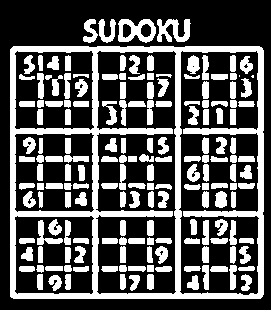

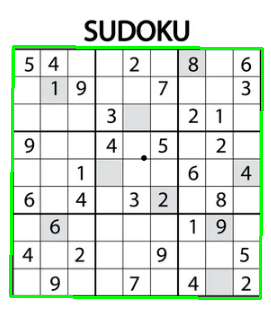

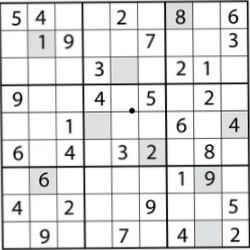

(array([[[255, 255, 255],
         [255, 255, 255],
         [254, 254, 254],
         ...,
         [116, 116, 116],
         [193, 193, 193],
         [254, 254, 254]],
 
        [[228, 228, 228],
         [228, 228, 228],
         [224, 224, 224],
         ...,
         [ 14,  14,  14],
         [126, 126, 126],
         [252, 252, 252]],
 
        [[104, 104, 104],
         [103, 103, 103],
         [101, 101, 101],
         ...,
         [ 17,  17,  17],
         [117, 117, 117],
         [248, 247, 248]],
 
        ...,
 
        [[252, 252, 252],
         [194, 194, 194],
         [ 64,  64,  64],
         ...,
         [ 60,  60,  60],
         [ 57,  57,  57],
         [ 68,  68,  68]],
 
        [[254, 254, 254],
         [194, 194, 194],
         [ 62,  62,  62],
         ...,
         [207, 207, 207],
         [207, 207, 207],
         [214, 214, 214]],
 
        [[253, 253, 253],
         [222, 222, 222],
         [121, 121, 121],
         ...,
         [253, 253, 253],
  

In [47]:
from google.colab.patches import cv2_imshow
find_puzzle(cv2.imread('/content/Screenshot 2023-10-26 184731.png'),True)

## **extract_digit:** Examines each cell of the Sudoku puzzle board and extracts the digit from the cell (provided there is a digit)

In [48]:
def extract_digit(cell, debug=False):
	# apply automatic thresholding to the cell and then clear any connected borders that touch the border of the cell
	thresh = cv2.threshold(cell, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
	thresh = clear_border(thresh)

	# check to debug
	if debug:
		cv2_imshow(thresh)

  # find contours in the thresholded cell
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)

	# if no contours were found than this is an empty cell
	if len(cnts) == 0:
		return None

	# otherwise, find the largest contour in the cell and create a mask for the contour
	c = max(cnts, key=cv2.contourArea)
	mask = np.zeros(thresh.shape, dtype="uint8")
	cv2.drawContours(mask, [c], -1, 255, -1)

  # compute the percentage of masked pixels relative to the total area of the image
	(h, w) = thresh.shape
	percentFilled = cv2.countNonZero(mask) / float(w * h)

	# if less than 3% of the mask is filled then we are looking at noise and can safely ignore the contour
	if percentFilled < 0.03:
		return None

	# apply the mask to the thresholded cell
	digit = cv2.bitwise_and(thresh, thresh, mask=mask)

	# check to see if we should visualize the masking step
	if debug:
		cv2_imshow(digit)

	# return the digit to the calling function
	return digit


## OCR of sudoku numbers

In [35]:
!pip install py-sudoku
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (20.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [49]:
from tensorflow.keras.preprocessing.image import img_to_array
from sudoku import Sudoku
import pytesseract
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

In [50]:
# load the digit classifier from disk
print("[INFO] loading digit classifier...")
NUM_MODELS = 3
models = [load_model(f"/content/Output/digit_classifier_lenetmodel_{i + 1}.h5") for i in range(NUM_MODELS)]

# load the input image from disk and resize it
print("[INFO] processing image...")
image = cv2.imread('/content/Screenshot 2023-10-26 184731.png')
image = imutils.resize(image, width=600)

# find the puzzle in the image and then
(puzzleImage, warped) = find_puzzle(image)

# initialize our 9x9 Sudoku board
board = np.zeros((9, 9), dtype="int")

# a Sudoku puzzle is a 9x9 grid (81 individual cells), so we can infer the location of each cell
# by dividing the warped image into a 9x9 grid
stepX = warped.shape[1] // 9
stepY = warped.shape[0] // 9

# initialize a list to store the (x, y)-coordinates of each cell location
cellLocs = []


[INFO] loading digit classifier...


[INFO] processing image...


In [51]:
# loop over the grid locations
for y in range(0, 9):
	# initialize the current list of cell locations
	row = []

	for x in range(0, 9):
		# compute the starting and ending (x, y)-coordinates of the
		# current cell
		startX = x * stepX
		startY = y * stepY
		endX = (x + 1) * stepX
		endY = (y + 1) * stepY

		# add the (x, y)-coordinates to our cell locations list
		row.append((startX, startY, endX, endY))
    # crop the cell from the warped transform image and then extract the digit from the cell
		cell = warped[startY:endY, startX:endX]
		digit = extract_digit(cell)

				# verify that the digit is not empty
		if digit is not None:
				# resize the cell to 28x28 pixels and then prepare the cell for classification
				roi = cv2.resize(digit, (28, 28))
				roi = roi.astype("float") / 255.0
				roi = img_to_array(roi)
				roi = np.expand_dims(roi, axis=0)

				# get predictions from all models and average them
				predictions = [model.predict(roi) for model in models]
				avg_prediction = np.average(predictions, axis=0)

				# classify the digit and update the Sudoku board with the prediction
				pred = avg_prediction.argmax(axis=1)[0]
				board[y, x] = pred

	# add the row to our cell locations
	cellLocs.append(row)

1/1 [==============================] - 0s 28ms/step


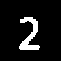

In [52]:
cv2_imshow(digit)

In [53]:
board

array([[5, 4, 0, 0, 2, 0, 8, 0, 6],
       [0, 1, 9, 0, 0, 7, 0, 0, 3],
       [0, 0, 0, 3, 0, 0, 2, 1, 0],
       [9, 0, 0, 4, 0, 5, 0, 2, 0],
       [0, 0, 1, 0, 0, 0, 6, 0, 4],
       [6, 0, 4, 0, 3, 2, 0, 8, 0],
       [0, 6, 0, 0, 0, 0, 1, 9, 0],
       [4, 0, 2, 0, 0, 9, 0, 0, 5],
       [0, 9, 0, 0, 7, 0, 4, 0, 2]])

[INFO] OCR'd Sudoku board:
+-------+-------+-------+
| 5 4   |   2   | 8   6 |
|   1 9 |     7 |     3 |
|       | 3     | 2 1   |
+-------+-------+-------+
| 9     | 4   5 |   2   |
|     1 |       | 6   4 |
| 6   4 |   3 2 |   8   |
+-------+-------+-------+
|   6   |       | 1 9   |
| 4   2 |     9 |     5 |
|   9   |   7   | 4   2 |
+-------+-------+-------+

[INFO] solving Sudoku puzzle...

---------------------------
9x9 (3x3) SUDOKU PUZZLE
Difficulty: SOLVED
---------------------------
+-------+-------+-------+
| 5 4 3 | 9 2 1 | 8 7 6 |
| 2 1 9 | 6 8 7 | 5 4 3 |
| 8 7 6 | 3 5 4 | 2 1 9 |
+-------+-------+-------+
| 9 8 7 | 4 6 5 | 3 2 1 |
| 3 2 1 | 7 9 8 | 6 5 4 |
| 6 5 4 | 1 3 2 | 9 8 7 |
+-------+-------+-------+
| 7 6 5 | 2 4 3 | 1 9 8 |
| 4 3 2 | 8 1 9 | 7 6 5 |
| 1 9 8 | 5 7 6 | 4 3 2 |
+-------+-------+-------+

        


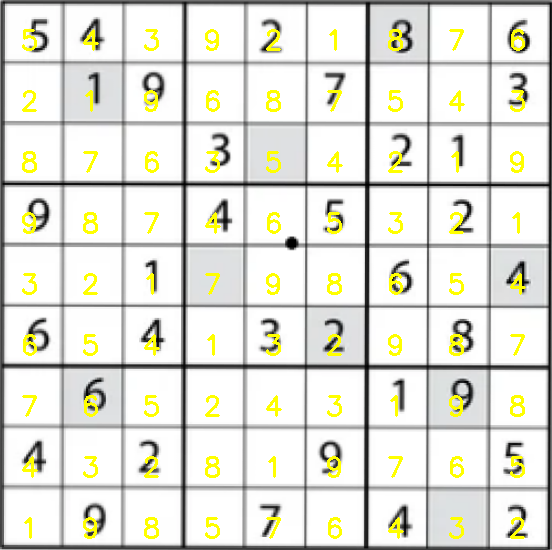

-1

In [54]:
# construct a Sudoku puzzle from the board
print("[INFO] OCR'd Sudoku board:")
puzzle = Sudoku(3, 3, board=board.tolist())
puzzle.show()

# solve the Sudoku puzzle
print("[INFO] solving Sudoku puzzle...")
solution = puzzle.solve()
solution.show_full()

# loop over the cell locations and board
for (cellRow, boardRow) in zip(cellLocs, solution.board):
	# loop over individual cell in the row
	for (box, digit) in zip(cellRow, boardRow):
		# unpack the cell coordinates
		startX, startY, endX, endY = box

		# compute the coordinates of where the digit will be drawn
		# on the output puzzle image
		textX = int((endX - startX) * 0.33)
		textY = int((endY - startY) * -0.2)
		textX += startX
		textY += endY

		# draw the result digit on the Sudoku puzzle image
		cv2.putText(puzzleImage, str(digit), (textX, textY),
			cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)

# show the output image
cv2_imshow(puzzleImage)
cv2.waitKey(0)